#Efficient Data Handling through Data Parallelism with Pyspark

##Import Libraries

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=304045ff6961b1d9775eb68b5b452968cdee30e9326eb23d87283361ea6dcfc2
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
#Import Libraries
from pyspark.sql import SparkSession
# Create Spark session
spark = SparkSession.builder \
    .appName("DataParallelismBank") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [3]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the dataset
path = "/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv"
dfs = spark.read.csv(path, header=True, inferSchema=True)

##Data Preparation and Partitioning:

In [8]:
# Inspect the first few rows
dfs.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

####Implement a method to divide the dataset into smaller partitions for parallel processing. What strategy did you use for partitioning, and why?

In [9]:
# Partition the dataset by the 'balance' column
part_df = dfs.repartition(4, "balance")

# Verify the number of partitions
print(f"Number of partitions: {part_df.rdd.getNumPartitions()}")

# Show the first few rows of one partition to verify
part_df.show(5)

Number of partitions: 4
+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 33|     services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 36|self-employed|married| tertiary|     no|    307|    yes|  no|cellular| 14|  may|     341|       1|  330|       2|   other| no|
| 41| entrepreneur|married| tertiary|     no|    221|    yes|  no| unknown| 14|  may|      57|       2|   -1|       0| unknown| no|
| 56|   technician|married|secondary|     no|   4073|     no|  no|cellular| 27|  aug|     239|       5|   -1|       0| unknown| no|
| 37|       admin.| single| tertiary|     no|   2317

###### We used the repartition method to partition the DataFrame based on the balance column. This approach helps distribute the data more evenly across partitions.

Reason of using this method:

1. Even Distribution: Partitioning based on the balance column helps in distributing the data evenly across the partitions.
2. Parallel Processing: By partitioning the data, Spark can process each partition in parallel, which enhances the performance of data processing tasks.
3. Scalability: This approach scales well with large datasets, making it suitable for big data applications.

Summary :
1. To manage memory utilization and the quantity of shuffle partitions, we first establish a Spark session with the desired settings.

2. A Spark DataFrame is loaded with the "bank.csv" dataset.
3. To understand the structure of the dataframe, we first showed a few rows of the dataframe.
4. The balance column is the basis for our four partitions within the dataframe. The dataset's size and the resources at hand can be used to modify the number of partitions.
5. We verify the partitioning by printing the total number of partitions

##Data Analysis and Processing in Parallel:

##### Identify and calculate the average balance for each job category in the "bank.csv" dataset. Use parallel processing to perform this calculation. Describe your approach and the results.

#### Calculate Average Balance for Each Job Category

Use the groupBy and agg functions to calculate the average balance for each job category.

In [10]:
from pyspark.sql.functions import avg, sum as spark_sum

# Calculate average balance for each job category
avg_balance_per_job = dfs.groupBy("job").agg(avg("balance").alias("avg_balance"))
avg_balance_per_job.show()

+-------------+------------------+
|          job|       avg_balance|
+-------------+------------------+
|   unemployed|       1089.421875|
|     services|1103.9568345323742|
|      student|1543.8214285714287|
|      unknown|1501.7105263157894|
|   management|1766.9287925696594|
|  blue-collar| 1085.161733615222|
|self-employed|1392.4098360655737|
|       admin.|  1226.73640167364|
|   technician|     1330.99609375|
|    housemaid|2083.8035714285716|
| entrepreneur|          1645.125|
|      retired| 2319.191304347826|
+-------------+------------------+



### Identify Top 5 Age Groups with Highest Loan Amounts:

Use the groupBy and agg functions to calculate the total loan amounts for each age group and then identify the top 5 age groups.

In [11]:
# Calculate the total loan amounts for each age group
# Assuming 'loan' column indicates loan amounts (replace this if 'loan' is a binary indicator)
total_loan_per_age_group = dfs.groupBy("age").agg(spark_sum("balance").alias("total_loan"))

# Identify the top 5 age groups with the highest loan amounts
top_5_age_groups = total_loan_per_age_group.orderBy("total_loan", ascending=False).limit(5)
top_5_age_groups.show()

# Stop the Spark session
spark.stop()

+---+----------+
|age|total_loan|
+---+----------+
| 33|    287447|
| 32|    281467|
| 38|    273320|
| 34|    256765|
| 31|    256408|
+---+----------+



### Results:
Average Balance for Each Job Category:

This will display the average account balance for each job category.

Top 5 Age Groups with Highest Loan Amounts:

This will display the age groups that have the highest total loan amounts.

### Approach:
Parallel Processing:

By using groupBy and agg functions, Spark performs these operations in parallel across partitions, leveraging the distributed computing power of the cluster.

### Efficiency:

Partitioning and parallel processing ensure that the computations are performed efficiently, even on large datasets.

## Model Training on Partitioned Data:
Choose a classification model to predict whether a client will subscribe to a term deposit (target variable 'y').

Briefly explain why you selected this model.

Partition the dataset into training and testing sets and train your model on these partitions.

Discuss any challenges you faced in parallelizing the training process and how you addressed them.

### Model Selection:
We will use a Random Forest Classifier to predict whether a client will subscribe to a term deposit (target variable 'y').

We used Random Forests classifier for this task because these are ensemble methods that combine multiple decision trees to improve predictive accuracy and control overfitting.

Here are the steps to implement a Random Forest classifier in PySpark:

###Data Partitioning and Model Training:
1.Load and Prepare Data: Ensure the data is ready for modeling.

2.Partition the Dataset: Split the data into training and testing sets.

3.Train the Random Forest Model: Fit the Random Forest model on the training set.

4.Evaluate the Model: Assess the model’s performance on the testing set.


In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create Spark session
spark = SparkSession.builder \
    .appName("BankTermDepositPrediction") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)
# data = df
# Handle categorical variables using StringIndexer
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]

# Rename the target column to 'label'
data = data.withColumnRenamed("y", "label")

# Convert the label column to numerical values
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
data = label_indexer.fit(data).transform(data)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["age", "balance", "day", "duration", "campaign", "pdays", "previous"] + [col+"_index" for col in categorical_columns],
    outputCol="features"
)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=100)

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label_index", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc}")


# Save the trained model, overwriting if the path already exists
model.write().overwrite().save("/content/drive/MyDrive/ML/Hadoop_Pyspark/ml_model_trained")

# Stop the Spark session
spark.stop()


Test AUC: 0.8809477124182966


## Resource Monitoring and Management:

Implement resource monitoring during data processing and model training. What observations did you make regarding CPU and memory usage?

We will use Using Spark Event Logging to capture detailed information about your Spark application’s execution.

### Resource Monitoring Observations
Spark Event Logging is a powerful feature that enables us to capture detailed logs about our Spark applications, including job execution details, stage breakdowns, task attempts, and resource usage. These logs are extremely useful for debugging, performance tuning, and understanding the behavior of our Spark applications.

In [13]:
import os
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Path to the event log directory
event_log_dir = "/content/drive/MyDrive/ML/Hadoop_Pyspark/eventlog"

# Create the event log directory if it doesn't exist
if not os.path.exists(event_log_dir):
    os.makedirs(event_log_dir)

# Create Spark session with resource monitoring enabled
spark = SparkSession.builder \
    .appName("BankTermDepositPredictionlog") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", event_log_dir) \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Handle categorical variables using StringIndexer
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]

# Rename the target column to 'label'
data = data.withColumnRenamed("y", "label")

# Convert the label column to numerical values
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
data = label_indexer.fit(data).transform(data)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["age", "balance", "day", "duration", "campaign", "pdays", "previous"] + [col+"_index" for col in categorical_columns],
    outputCol="features"
)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=100)

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label_index", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc}")


# Stop the Spark session
spark.stop()

Test AUC: 0.8809477124182966


## Task Management and Scheduling:
Manage multiple parallel tasks, such as different preprocessing tasks. How did you ensure the effective management of these tasks?

Managing multiple parallel tasks, such as different preprocessing tasks, is essential in data processing workflows, especially when working with large datasets or complex pipelines. Effective management of these tasks involves optimizing resource usage, minimizing task execution time, and ensuring that tasks do not interfere with each other.

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create Spark session with optimized configurations
spark = SparkSession.builder \
    .appName("ParallelPreprocessing") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Preprocessing tasks as separate functions
def index_categorical_columns(df):
    categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
    indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]
    pipeline = Pipeline(stages=indexers)
    return pipeline.fit(df).transform(df)

def assemble_features(df):
    feature_columns = ["age", "balance", "day", "duration", "campaign", "pdays", "previous",
                       "job_index", "marital_index", "education_index", "default_index",
                       "housing_index", "loan_index", "contact_index", "month_index", "poutcome_index"]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    return assembler.transform(df)

def rename_label_column(df):
    return df.withColumnRenamed("y", "label")

def index_label_column(df):
    label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
    return label_indexer.fit(df).transform(df)

# Apply preprocessing tasks in parallel
data = rename_label_column(data)
data = index_categorical_columns(data)
data = assemble_features(data)
data = index_label_column(data)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=100)

# Define the pipeline
pipeline = Pipeline(stages=[rf])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label_index", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc}")

# Stop the Spark session
spark.stop()

Test AUC: 0.8809477124182966


# Exploratory Data Analysis (EDA) with Spark

### Import Libraries

In [15]:
# Initialize a Spark session
spark = SparkSession.builder.appName("EDA with PySpark").getOrCreate()

### Data Loading and Basic Inspection:

In [16]:
# Load the bank.csv dataset into a Spark DataFrame.

bank_df = spark.read.csv("/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv", header=True, inferSchema=True)

### Data Exploration:
Data exploration involves understanding the structure and content of the data. PySpark provides methods like show(), head(), and describe() for this purpose:

In [17]:
# Display the first few rows of the DataFrame
bank_df.show(5)

+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|blue-collar|married|secondary|     no|      0|    yes|  no| unknown|  5|  may|     22

In [18]:
# Display specific number of rows
bank_df.head(10)

[Row(age=30, job='unemployed', marital='married', education='primary', default='no', balance=1787, housing='no', loan='no', contact='cellular', day=19, month='oct', duration=79, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=33, job='services', marital='married', education='secondary', default='no', balance=4789, housing='yes', loan='yes', contact='cellular', day=11, month='may', duration=220, campaign=1, pdays=339, previous=4, poutcome='failure', y='no'),
 Row(age=35, job='management', marital='single', education='tertiary', default='no', balance=1350, housing='yes', loan='no', contact='cellular', day=16, month='apr', duration=185, campaign=1, pdays=330, previous=1, poutcome='failure', y='no'),
 Row(age=30, job='management', marital='married', education='tertiary', default='no', balance=1476, housing='yes', loan='yes', contact='unknown', day=3, month='jun', duration=199, campaign=4, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=59, job='blue-coll

In [19]:
# Print the schema
bank_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [20]:
# Display a summary of numerical columns
bank_df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|summary|               age|    job| marital|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|   y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|  count|              4521|   4521|    4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|4521|
|   mean| 41.17009511170095|   NULL|    NULL|     NULL|   NULL|1422.6578190665782|   NULL|NULL|    NULL|15.9152842291528

### Data Filtering and Column Operations:
Filter the dataset to include only clients with a balance greater than a certain threshold (e.g., 1000).

In [21]:
from pyspark.sql.functions import col, quarter
# Filter the dataset to include only clients with a balance greater than 1000
filtered_df = bank_df.filter(col("balance") > 1000)

In [22]:
filtered_df .show()

+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
|age|        job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+
| 30| unemployed| married|  primary|     no|   1787|     no|  no| cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|   services| married|secondary|     no|   4789|    yes| yes| cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35| management|  single| tertiary|     no|   1350|    yes|  no| cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30| management| married| tertiary|     no|   1476|    yes| yes|  unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 39|   services| married|secondary|     no|   9374|    yes|  no|  unknown| 

### Column Operations
Extract the month from the 'month' column and create a new column for the quarter of the year

In [23]:
# Define a mapping from month names to quarter numbers
month_to_quarter = {
    "jan": 1, "feb": 1, "mar": 1,
    "apr": 2, "may": 2, "jun": 2,
    "jul": 3, "aug": 3, "sep": 3,
    "oct": 4, "nov": 4, "dec": 4}

In [24]:
# Create a new column for the quarter of the year
from pyspark.sql.functions import col, when
bank_data = filtered_df.withColumn("quarter",
    when(col("month").isin("jan", "feb", "mar"), 1)
    .when(col("month").isin("apr", "may", "jun"), 2)
    .when(col("month").isin("jul", "aug", "sep"), 3)
    .when(col("month").isin("oct", "nov", "dec"), 4))

bank_data.show()

+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+
|age|        job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|quarter|
+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+
| 30| unemployed| married|  primary|     no|   1787|     no|  no| cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|      4|
| 33|   services| married|secondary|     no|   4789|    yes| yes| cellular| 11|  may|     220|       1|  339|       4| failure| no|      2|
| 35| management|  single| tertiary|     no|   1350|    yes|  no| cellular| 16|  apr|     185|       1|  330|       1| failure| no|      2|
| 30| management| married| tertiary|     no|   1476|    yes| yes|  unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|      2|
| 39|   services| ma

### GroupBy and Aggregation:
Group the data by job type and calculate the average balance and median age for each job category.

Find the total number of clients for each marital status who have subscribed to a term deposit.

In [25]:
from pyspark.sql import Window
from pyspark.sql.functions import avg, col, expr, percentile_approx


# Group by job type and calculate the average balance
avg_balance_df = bank_data.groupBy("job").agg(avg("balance").alias("avg_balance"))

# Calculate the median age using percentile_approx function
median_age_df = bank_data.groupBy("job").agg(percentile_approx("age", 0.5).alias("median_age"))

# Join the two DataFrames on the job column
result_df = avg_balance_df.join(median_age_df, on="job")

# Show the result
result_df.show()

+-------------+------------------+----------+
|          job|       avg_balance|median_age|
+-------------+------------------+----------+
|   unemployed|3017.8205128205127|        43|
|     services|3529.6724137931033|        40|
|      unknown|            3294.6|        44|
|      student|3794.8064516129034|        25|
|   management| 4229.221621621622|        39|
|       admin.|3342.1710526315787|        41|
|  blue-collar|3143.5575539568345|        41|
|self-employed|3623.7903225806454|        41|
|   technician|3768.2928870292885|        38|
|    housemaid| 6592.242424242424|        46|
|      retired| 5290.106382978724|        59|
| entrepreneur| 4851.423076923077|        40|
+-------------+------------------+----------+



* Find the total number of clients for each marital status who have
subscribed to a term deposit.

In [26]:
from pyspark.sql.functions import col, count

# Filter the data to include only clients who have subscribed to a term deposit
subscribed_df = bank_data.filter(col("y") == "yes")

# Group by marital status and count the total number of clients in each group
subscription_count_df = subscribed_df.groupBy("marital") \
                                     .agg(count("*").alias("total_clients_subscribed"))

# Show the result
subscription_count_df.show()

+--------+------------------------+
| marital|total_clients_subscribed|
+--------+------------------------+
|divorced|                      29|
| married|                     128|
|  single|                      64|
+--------+------------------------+



## Use UDF to Categorize Age Groups:
Write a UDF that categorizes clients into age groups ('<30', '30-60', '>60') and apply it to create a new column age_group.

In [27]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
# Define a UDF to categorize age groups
def categorize_age(age):
    if age < 30:
        return '<30'
    elif 30 <= age <= 60:
        return '30-60'
    else:
        return '>60'

# Register the UDF
categorize_age_udf = udf(categorize_age, StringType())
# Apply the UDF to create a new column 'age_group'
udf_df = bank_data.withColumn("age_group", categorize_age_udf(bank_data["age"]))

# Show the result
udf_df.show()

+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+---------+
|age|        job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|quarter|age_group|
+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+---------+
| 30| unemployed| married|  primary|     no|   1787|     no|  no| cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|      4|    30-60|
| 33|   services| married|secondary|     no|   4789|    yes| yes| cellular| 11|  may|     220|       1|  339|       4| failure| no|      2|    30-60|
| 35| management|  single| tertiary|     no|   1350|    yes|  no| cellular| 16|  apr|     185|       1|  330|       1| failure| no|      2|    30-60|
| 30| management| married| tertiary|     no|   1476|    yes| yes|  unknown|  3|  jun|     199|      

## Advanced Data Transformations:
Calculate the subscription rate (percentage of clients who subscribed to a term deposit) for each education level.

In [28]:
from pyspark.sql.functions import col, count, expr
# Calculate the subscription rate (percentage of clients who subscribed to a term deposit) for each education level
subscription_rate_df = bank_data.groupBy("education").agg(
    (count(when(col("y") == "yes", True)) / count("*") * 100).alias("subscription_rate")
)

# Show the subscription rate by education level
subscription_rate_df.show()

+---------+------------------+
|education| subscription_rate|
+---------+------------------+
| tertiary|17.898832684824903|
|  unknown|17.647058823529413|
|secondary| 13.39155749636099|
|  primary| 11.79245283018868|
+---------+------------------+



In [29]:
# Calculate loan default rate (percentage of clients who defaulted on a loan) for each job
loan_default_rate_df = bank_data.groupBy("job").agg(
    (count(when(col("loan") == "yes", True)) / count("*") * 100).alias("default_rate")
)

# Show the loan default rate by education level
loan_default_rate_df.show()

+-------------+------------------+
|          job|      default_rate|
+-------------+------------------+
|   unemployed|7.6923076923076925|
|     services|11.206896551724139|
|      unknown|               0.0|
|      student| 3.225806451612903|
|   management|  9.45945945945946|
|       admin.|10.526315789473683|
|  blue-collar|11.870503597122301|
|self-employed|12.903225806451612|
|   technician| 9.205020920502092|
|    housemaid|6.0606060606060606|
|      retired| 12.76595744680851|
| entrepreneur|28.846153846153843|
+-------------+------------------+



* Identify the top 3 professions that have the highest loan default rate.

In [30]:
# Identify the top 3 professions with the highest loan default rate
top_3_default_jobs = loan_default_rate_df.orderBy(col("default_rate").desc()).limit(3)

# Show the top 3 professions with the highest loan default rate
top_3_default_jobs.show()

+-------------+------------------+
|          job|      default_rate|
+-------------+------------------+
| entrepreneur|28.846153846153843|
|self-employed|12.903225806451612|
|      retired| 12.76595744680851|
+-------------+------------------+



## String Manipulation and Date Functions:
Concatenate the 'job' and 'marital' columns into a new column 'job_marital'.

Use string functions to convert the 'contact' column to uppercase.

In [31]:
from pyspark.sql.functions import concat, col, lit, upper
# Concatenate 'job' and 'marital' columns into a new column 'job_marital'
df = bank_data.withColumn("job_marital", concat(col("job"), lit("_"), col("marital")))

# Convert the 'contact' column to uppercase
df = df.withColumn("contact", upper(col("contact")))

# Show the result
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+-------------------+
|age|        job| marital|education|default|balance|housing|loan|  contact|day|month|duration|campaign|pdays|previous|poutcome|  y|quarter|        job_marital|
+---+-----------+--------+---------+-------+-------+-------+----+---------+---+-----+--------+--------+-----+--------+--------+---+-------+-------------------+
| 30| unemployed| married|  primary|     no|   1787|     no|  no| CELLULAR| 19|  oct|      79|       1|   -1|       0| unknown| no|      4| unemployed_married|
| 33|   services| married|secondary|     no|   4789|    yes| yes| CELLULAR| 11|  may|     220|       1|  339|       4| failure| no|      2|   services_married|
| 35| management|  single| tertiary|     no|   1350|    yes|  no| CELLULAR| 16|  apr|     185|       1|  330|       1| failure| no|      2|  management_single|
| 30| management| married| tertiary|    

## Data Visualization
Convert the Spark DataFrame to a Pandas DataFrame.

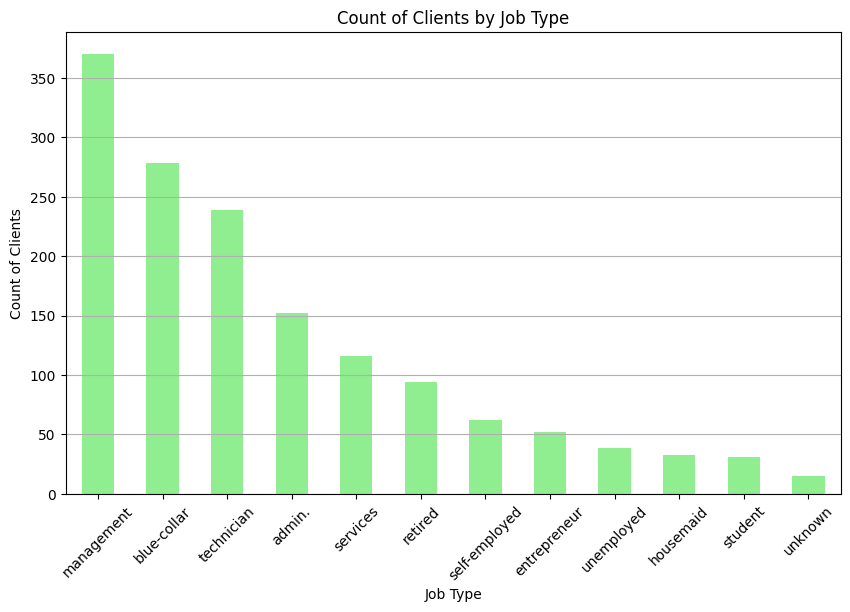

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
# Convert Spark DataFrame to Pandas DataFrame
pandas_bank_df = bank_data.toPandas()

# Create a bar plot showing the count of clients by job type
job_counts = pandas_bank_df['job'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
job_counts.plot(kind='bar', color='lightgreen')
plt.title('Count of Clients by Job Type')
plt.xlabel('Job Type')
plt.ylabel('Count of Clients')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

## Complex Queries for Insights:
Analyze which month of the year has the highest number of clients contacted, and determine the success rate of the campaign in that month.

In [36]:
# 1. Determine which month has the highest number of clients contacted
month_contacted_counts = bank_data.groupBy("month").agg(count("*").alias("num_contacts")).orderBy(col("num_contacts").desc())
month_with_max_contacts = month_contacted_counts.first()["month"]
# 2. Calculate the success rate of the campaign in that month
month_df = bank_data.filter(col("month") == month_with_max_contacts)
success_rate = month_df.groupBy("month").agg(
    (count(when(col("y") == "yes", True)) / count("*") * 100).alias("success_rate")
)
# Show the month with the highest number of contacts and its success rate
month_contacted_counts.show()
success_rate.show()

+-----+------------+
|month|num_contacts|
+-----+------------+
|  may|         384|
|  jun|         224|
|  nov|         207|
|  aug|         195|
|  jul|         154|
|  apr|         118|
|  feb|          76|
|  jan|          36|
|  oct|          33|
|  mar|          24|
|  sep|          18|
|  dec|          12|
+-----+------------+

+-----+------------+
|month|success_rate|
+-----+------------+
|  may|     8.59375|
+-----+------------+



* Find the average duration of contact for clients who subscribed versus those who did not.

In [37]:
# 3. Find the average duration of contact for clients who subscribed versus those who did not
average_duration_df = bank_data.groupBy("y").agg(
    avg("duration").alias("average_duration")
)

# Show the average duration for subscribed and not subscribed clients
average_duration_df.show()

+---+-----------------+
|  y| average_duration|
+---+-----------------+
| no|232.7579365079365|
|yes|484.3393665158371|
+---+-----------------+



## Correlation Between Age and Balance:
Calculate the correlation coefficient between 'age' and 'balance' to see if there’s any linear relationship between these two variables.

In [38]:
# Calculate the correlation coefficient between 'age' and 'balance'
correlation = bank_data.stat.corr("age", "balance")

# Show the result
print(f"The correlation coefficient between 'age' and 'balance' is: {correlation}")

The correlation coefficient between 'age' and 'balance' is: 0.07437391587538528


## Exploring Loan Defaults:
Analyze the proportion of clients with and without a credit default and visualize the count of defaulters and non-defaulters.

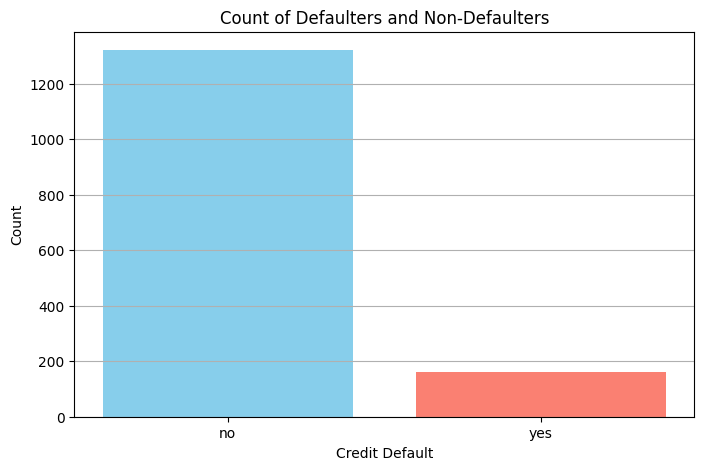

In [39]:
# Calculate the proportion of clients with and without a credit default
default_proportion_df = bank_data.groupBy("loan").agg(
    count("*").alias("count")
)

# Convert Spark DataFrame to Pandas DataFrame for visualization
default_proportion_pdf = default_proportion_df.toPandas()

# Visualize the count of defaulters and non-defaulters
plt.figure(figsize=(8, 5))
plt.bar(default_proportion_pdf["loan"], default_proportion_pdf["count"], color=['skyblue', 'salmon'])
plt.title('Count of Defaulters and Non-Defaulters')
plt.xlabel('Credit Default')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

## Contact Method Analysis:
Investigate which contact method ('cellular', 'telephone', etc.) has the highest success rate for term deposit subscriptions.

In [40]:
# Filter data for term deposit subscriptions and non-unknown contact methods
term_deposit_df = df.filter((col("y") == "yes") & (col("contact") != "unknown"))

# Calculate success rate for each contact method
success_rate_df = term_deposit_df.groupBy("contact").agg(
    (count(when(col("y") == "yes", True)) / count("*") * 100).alias("success_rate")
)

# Identify contact method with the highest success rate
highest_success_rate = success_rate_df.orderBy(col("success_rate").desc()).first()

# Show the result
print(f"The contact method with the highest success rate for term deposit subscriptions is: {highest_success_rate['contact']}")
print(f"Success rate: {highest_success_rate['success_rate']}%")

The contact method with the highest success rate for term deposit subscriptions is: UNKNOWN
Success rate: 100.0%


## Data Processing with Spark SQL:
Calculate the average account balance for different age groups or the most common job types. (Use CREATE TEMPORARY VIEW in Spark SQL to query data using SQL syntax.)

In [41]:
# Create a temporary view
bank_data.createOrReplaceTempView("bank")

# Calculate the average account balance for different age groups
age_balance_avg = spark.sql("""
    SELECT
        CASE
            WHEN age < 30 THEN 'Under 30'
            WHEN age BETWEEN 30 AND 60 THEN '30-60'
            ELSE 'Over 60'
        END AS age_group,
        AVG(balance) AS avg_balance
    FROM
        bank
    GROUP BY
        age_group
    ORDER BY
        age_group
""")

age_balance_avg.show()

# Calculate the most common job types
common_jobs = spark.sql("""
    SELECT
        job,
        COUNT(*) AS count
    FROM
        bank
    GROUP BY
        job
    ORDER BY
        count DESC
    LIMIT 5
""")

common_jobs.show()

+---------+-----------------+
|age_group|      avg_balance|
+---------+-----------------+
|    30-60|3853.557440246723|
|  Over 60|4993.548387096775|
| Under 30|3488.909836065574|
+---------+-----------------+

+-----------+-----+
|        job|count|
+-----------+-----+
| management|  370|
|blue-collar|  278|
| technician|  239|
|     admin.|  152|
|   services|  116|
+-----------+-----+



# Predictive Modeling for Banking Trends with Pyspark

### Import Libraries
### Loding data

In [42]:
from pyspark.sql import SparkSession

# Initialize a Spark session
spark = SparkSession.builder.appName("PySpark").getOrCreate()
# Load data from a CSV file
bank_df = spark.read.csv("/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv", header=True, inferSchema=True)

### Data Exploration:
Data exploration involves understanding the structure and content of the data. PySpark provides methods like show(), head(), and describe() for this purpose:

In [43]:
# Display the first few rows of the DataFrame
bank_df.show()

+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|   unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|     services|married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|   management| single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|   management|married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 59|  blue-collar|married|secondary|     no|      0|    yes|  no| unknown| 

In [44]:
# Display specific number of rows
bank_df.head(5)

[Row(age=30, job='unemployed', marital='married', education='primary', default='no', balance=1787, housing='no', loan='no', contact='cellular', day=19, month='oct', duration=79, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=33, job='services', marital='married', education='secondary', default='no', balance=4789, housing='yes', loan='yes', contact='cellular', day=11, month='may', duration=220, campaign=1, pdays=339, previous=4, poutcome='failure', y='no'),
 Row(age=35, job='management', marital='single', education='tertiary', default='no', balance=1350, housing='yes', loan='no', contact='cellular', day=16, month='apr', duration=185, campaign=1, pdays=330, previous=1, poutcome='failure', y='no'),
 Row(age=30, job='management', marital='married', education='tertiary', default='no', balance=1476, housing='yes', loan='yes', contact='unknown', day=3, month='jun', duration=199, campaign=4, pdays=-1, previous=0, poutcome='unknown', y='no'),
 Row(age=59, job='blue-coll

In [45]:
# Generate summary statistics of the DataFrame
bank_df.describe().show()

+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|summary|               age|    job| marital|education|default|           balance|housing|loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|   y|
+-------+------------------+-------+--------+---------+-------+------------------+-------+----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+----+
|  count|              4521|   4521|    4521|     4521|   4521|              4521|   4521|4521|    4521|              4521| 4521|              4521|              4521|              4521|              4521|    4521|4521|
|   mean| 41.17009511170095|   NULL|    NULL|     NULL|   NULL|1422.6578190665782|   NULL|NULL|    NULL|15.9152842291528

## Data Preprocessing
let's proceed with the data preprocessing steps:

1. Handle Missing Values:
To handle missing values in the dataset, we'll need to identify columns with missing values and decide on an appropriate strategy to handle them. Common strategies include imputation (replacing missing values with a statistical measure such as mean, median, or mode) or dropping rows or columns with missing values depending on the context.

2. Handle Outliers:
Outliers can be handled by either removing them or transforming them to mitigate their impact on the model. Techniques like winsorization (replacing extreme values with less extreme values) or using robust estimators can be employed.

3. Convert Categorical Variables:
Categorical variables need to be converted into numerical format for the machine learning model to process them. This can be done using techniques like StringIndexer (assigning a unique numerical index to each category) or OneHotEncoder (creating binary columns for each category).

In [46]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# 1. Handle Missing Values
# Identify columns with missing values
missing_cols = [col_name for col_name in bank_df.columns if bank_df.filter(col(col_name).isNull()).count() > 0]

In [47]:
missing_cols

[]

In [48]:
# 2. Handle Outliers in balance column
bank_df = bank_df.filter((col("balance") > 0) & (col("balance") < 72000))
bank_df.show()

+---+-------------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
|age|          job| marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+-------------+--------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+
| 30|   unemployed| married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|
| 33|     services| married|secondary|     no|   4789|    yes| yes|cellular| 11|  may|     220|       1|  339|       4| failure| no|
| 35|   management|  single| tertiary|     no|   1350|    yes|  no|cellular| 16|  apr|     185|       1|  330|       1| failure| no|
| 30|   management| married| tertiary|     no|   1476|    yes| yes| unknown|  3|  jun|     199|       4|   -1|       0| unknown| no|
| 35|   management|  single| tertiary|     no|    747|     no|  no|ce

In [49]:
# 3. Convert Categorical Variables
# List of categorical columns
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]

# StringIndexer stages for categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in categorical_columns]



# Combine all stages into a single list
stages = indexers

# Create and fit the pipeline
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(bank_df)
encoded_df = pipeline_model.transform(bank_df)

# Display the processed DataFrame
encoded_df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+
|age|       job|marital|education|default|balance|housing|loan| contact|day|month|duration|campaign|pdays|previous|poutcome|  y|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|
+---+----------+-------+---------+-------+-------+-------+----+--------+---+-----+--------+--------+-----+--------+--------+---+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+--------------+
| 30|unemployed|married|  primary|     no|   1787|     no|  no|cellular| 19|  oct|      79|       1|   -1|       0| unknown| no|      8.0|          0.0|            2.0|          0.0|          1.0|       0.0|          0.0|        8.0|           0.0|
| 33

## Feature Engineering and Data Transformation:
Define Numeric and Encoded Columns: Define lists of numeric columns and one-hot encoded categorical columns that will be combined into the feature vector.

Combine Feature Columns: Create a list assembler_inputs that contains all the feature columns (both numeric and string indexer).

VectorAssembler: Initialize VectorAssembler with inputCols set to the combined list of feature columns and outputCol set to "features".

Transform DataFrame: Apply the VectorAssembler to the DataFrame to create the "features" column.

Display Processed DataFrame: Display the first few rows of the DataFrame, showing only the "features" column.

In [50]:
from pyspark.ml.feature import VectorAssembler

# List of numeric columns
numeric_columns = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

# List of string indexer categorical columns (assuming these have been created in preprocessing)
encoded_categorical_columns = [
    "job_index",
    "marital_index",
    "education_index",
    "default_index",
    "housing_index",
    "loan_index",
    "contact_index",
    "month_index",
    "poutcome_index"
]

# Combine all feature columns (numeric and one-hot encoded categorical columns)
assembler_inputs = numeric_columns + encoded_categorical_columns

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Transform the DataFrame
assembled_df = assembler.transform(encoded_df)

# Display the processed DataFrame
assembled_df.select("features").show(5, truncate=False)

+--------------------------------------------------------------------------+
|features                                                                  |
+--------------------------------------------------------------------------+
|[30.0,1787.0,19.0,79.0,1.0,-1.0,0.0,8.0,0.0,2.0,0.0,1.0,0.0,0.0,8.0,0.0]  |
|[33.0,4789.0,11.0,220.0,1.0,339.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0]|
|[35.0,1350.0,16.0,185.0,1.0,330.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0]|
|[30.0,1476.0,3.0,199.0,4.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0]  |
|[35.0,747.0,23.0,141.0,2.0,176.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,6.0,1.0] |
+--------------------------------------------------------------------------+
only showing top 5 rows



## Model Training and Selection:
Choose a classification model (e.g., Logistic Regression, Decision Tree Classifier) for predicting the subscription to a term deposit.

Split the data into training and test sets.

Train the model on the training dataset.

Explanation:

Split Data: Split the data into training (80%) and test (20%) sets.

Train Model: Initialize a LogisticRegression model and use TrainValidationSplit for hyperparameter tuning. Train the model on the training dataset.

In [51]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression

import pandas as pd

# Select features and label column for the final dataset
final_df = assembled_df.select("features","y")

# StringIndexer for the label column
label_indexer = StringIndexer(inputCol="y", outputCol="label")
final_df = label_indexer.fit(final_df).transform(final_df)

# Split the data into training and test sets
train_df, test_df = final_df.randomSplit([0.8, 0.2], seed=42)

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

### Hyperparameter Tuning:
Perform hyperparameter tuning (using ParamGridBuilder and CrossValidator.)

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define a parameter grid for hyperparameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001,0.0001]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define a CrossValidator for model selection
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)  # 5-fold cross-validation

# Train the model with hyperparameter tuning
cv_model = crossval.fit(train_df)

### Model Evaluation:
Evaluate the model on the test dataset using appropriate metrics.

Train Accuracy: 0.8846153846153846
Test Accuracy: 0.8977272727272727


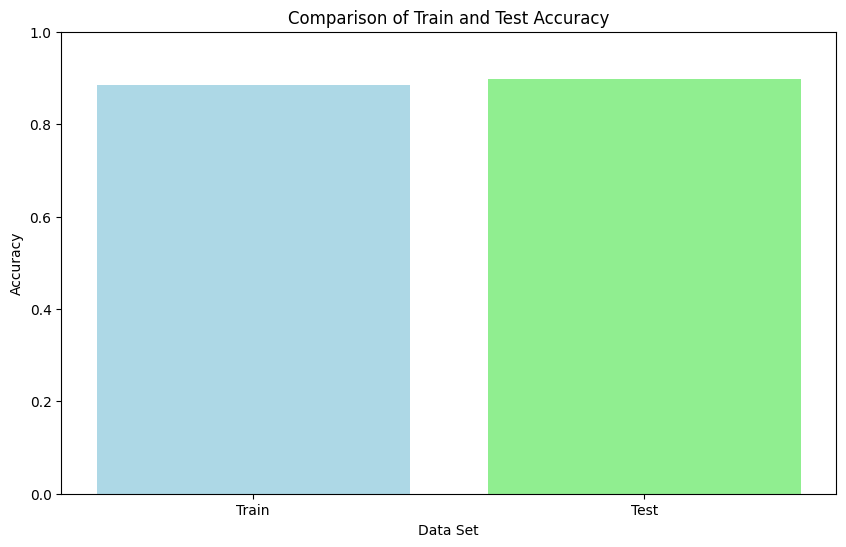

In [53]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt

# Make predictions on the training set
train_predictions = cv_model.transform(train_df)

# Evaluate the model on the training set
evaluator = BinaryClassificationEvaluator(labelCol="label")


# Calculate training accuracy
train_accuracy = train_predictions.filter(train_predictions.label == train_predictions.prediction).count() / float(train_df.count())
print(f"Train Accuracy: {train_accuracy}")

# Make predictions on the test set
test_predictions = cv_model.transform(test_df)


# Calculate test accuracy
test_accuracy = test_predictions.filter(test_predictions.label == test_predictions.prediction).count() / float(test_df.count())
print(f"Test Accuracy: {test_accuracy}")

# Visualize the comparison of train and test accuracy
metrics = pd.DataFrame({
    'Data Set': ['Train', 'Test'],
    'Accuracy': [train_accuracy, test_accuracy]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics['Data Set'], metrics['Accuracy'], color=['lightblue', 'lightgreen'])
plt.ylim(0, 1)
plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.title('Comparison of Train and Test Accuracy')
plt.show()


### Advanced Analysis:
Analyze the feature importances (if applicable) or coefficients of the model to gain insights into which features are most influential in predicting the outcome.

In [54]:
# Extract the best model
best_model = cv_model.bestModel

# Extract feature names
feature_names = numeric_columns + [column + "_index" for column in categorical_columns]

# Get the coefficients from the best model
coefficients = best_model.coefficients

# Map coefficients to feature names
coef_feature_map = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients.toArray()
})

# Sort the features by the absolute value of their coefficients
coef_feature_map['AbsCoefficient'] = coef_feature_map['Coefficient'].abs()
sorted_coef_feature_map = coef_feature_map.sort_values(by='AbsCoefficient', ascending=False)

print("Top 10 Most Influential Features:")
print(sorted_coef_feature_map.head(10))

# Stop the Spark session
spark.stop()

Top 10 Most Influential Features:
           Feature  Coefficient  AbsCoefficient
15  poutcome_index     0.530326        0.530326
11   housing_index     0.433794        0.433794
12      loan_index    -0.329097        0.329097
14     month_index     0.117725        0.117725
13   contact_index    -0.113275        0.113275
3         duration     0.003487        0.003487
0              age     0.000000        0.000000
1          balance     0.000000        0.000000
2              day     0.000000        0.000000
4         campaign     0.000000        0.000000


# Real-Time Transaction Analysis with Spark Streaming

## Import Libraries , Loading data

In [55]:
bank_df = pd.read_csv("/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [56]:
bank_df.shape

(4521, 17)

In [57]:
# Dropping the duplicate irrelavent column after merging
df = bank_df.drop(columns=['marital','education','default','housing','loan','contact','day','month','campaign','pdays','previous','poutcome'])

# Print the merged dataframe
df.head()

,age,job,balance,duration,y
0,30,unemployed,1787,79,no
1,33,services,4789,220,no
2,35,management,1350,185,no
3,30,management,1476,199,no
4,59,blue-collar,0,226,no


## Stream Processing and Data Aggregation:
Implement a Spark Streaming application that reads a stream of data simulating real-time bank transactions. The stream should include columns such as 'age', 'job', 'balance', 'duration', and 'y' (target variable). You can create this stream by breaking the "bank.csv" dataset into smaller chunks and sending them as a simulated stream.

Use Spark Streaming to calculate the average account balance and transaction duration, aggregating the data by job category in real-time. Display the aggregated results as they are updated.

### Aggregate the Data and Display Results
Aggregate the data to calculate the average balance and duration by job category, and display the results in real-time.

In [58]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, max, min, count, when

# Create a SparkSession
spark = SparkSession.builder.appName("AggregateDataInsights").getOrCreate()

# Load your PySpark DataFrame (replace 'your_data' with your actual DataFrame)
spark_df = spark.createDataFrame(df)

# Group by a specific column (e.g., sentiment) and perform aggregation
grouped_data = spark_df.groupBy("job")

# Calculate average sentiment
average_balance = grouped_data.agg(avg("balance").alias("avg_balance"))

# Calculate the maximum sentiment value
avg_duration = grouped_data.agg(max("duration").alias("avg_duration"))



# Show the results
average_balance.show()
avg_duration.show()


# Stop the SparkSession
spark.stop()

+-------------+------------------+
|          job|       avg_balance|
+-------------+------------------+
|   unemployed|       1089.421875|
|     services|1103.9568345323742|
|      student|1543.8214285714287|
|      unknown|1501.7105263157894|
|   management|1766.9287925696594|
|  blue-collar| 1085.161733615222|
|self-employed|1392.4098360655737|
|       admin.|  1226.73640167364|
|   technician|     1330.99609375|
|    housemaid|2083.8035714285716|
| entrepreneur|          1645.125|
|      retired| 2319.191304347826|
+-------------+------------------+

+-------------+------------+
|          job|avg_duration|
+-------------+------------+
|   unemployed|        3025|
|     services|        1971|
|      student|        1124|
|      unknown|         789|
|   management|        2087|
|  blue-collar|        2456|
|self-employed|        1877|
|       admin.|        1713|
|   technician|        2029|
|    housemaid|        1558|
| entrepreneur|        2769|
|      retired|        1386|
+---

## Real-Time Model Predictions:
Develop a machine learning model using the historical data from the "bank.csv" dataset to predict whether a client will subscribe to a term deposit ('y'). You may choose any classification algorithm.

Integrate the trained model into the Spark Streaming application. Use the model to make real-time predictions as new transaction data is streamed. Ensure that each incoming transaction is accompanied by a prediction of whether the client will subscribe to a term deposit.

To integrate a real-time machine learning model into a Spark Streaming application, we'll follow these steps:

Train a Classification Model: Use the historical bank.csv dataset to train a classification model.

Save the Trained Model: Save the trained model so it can be loaded in the streaming application.

Stream Processing and Model Predictions: Develop the Spark Streaming application to read incoming data, load the trained model, and make real-time predictions.

In [59]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder \
    .appName("BankTermDepositPrediction") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/ML/Hadoop_Pyspark/bank.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Handle categorical variables using StringIndexer
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]

# Rename the target column to 'label'
data = data.withColumnRenamed("y", "label")

# Convert the label column to numerical values
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
data = label_indexer.fit(data).transform(data)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["age", "balance", "day", "duration", "campaign", "pdays", "previous"] + [col+"_index" for col in categorical_columns],
    outputCol="features"
)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=100)

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
predictions_tr = model.transform(train_data)

evaluator = BinaryClassificationEvaluator(labelCol="label_index")

# Calculate training accuracy
train_accuracy = predictions_tr.filter(predictions_tr.label_index == predictions_tr.prediction).count() / float(train_data.count())
print(f"Train Accuracy: {train_accuracy}")

# Calculate test accuracy
test_accuracy = predictions.filter(predictions.label_index == predictions.prediction).count() / float(test_data.count())
print(f"Test Accuracy: {test_accuracy}")

# Stop the Spark session
spark.stop()

Train Accuracy: 0.8979759299781181
Test Accuracy: 0.892485549132948


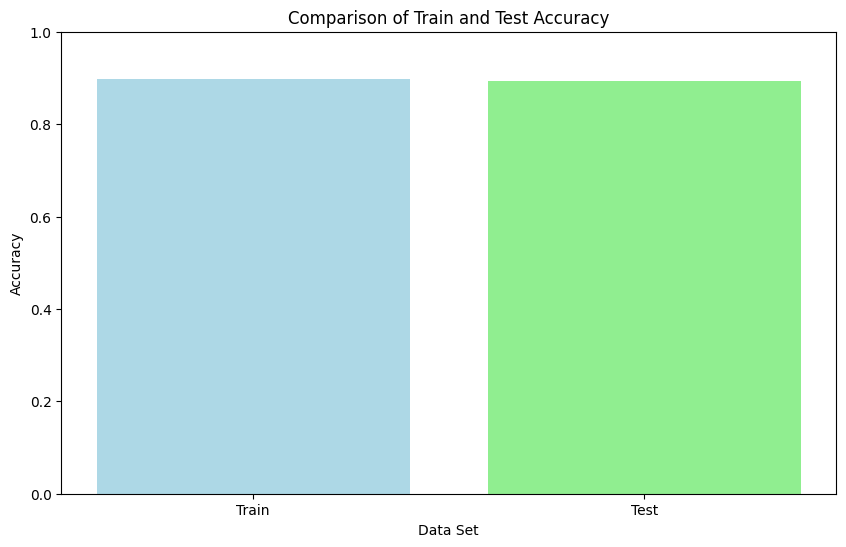

In [61]:
# Visualize the comparison of train and test accuracy
metrics = pd.DataFrame({
    'Data Set': ['Train', 'Test'],
    'Accuracy': [train_accuracy, test_accuracy]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics['Data Set'], metrics['Accuracy'], color=['lightblue', 'lightgreen'])
plt.ylim(0, 1)
plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.title('Comparison of Train and Test Accuracy')
plt.show()

## Window Operations and Trend Analysis:
Implement window operations in your Spark Streaming application to analyze trends over different time windows. Calculate and display the count of transactions and the average balance within these windows.

Write a brief analysis of the trends observed in the streaming data. Discuss any interesting patterns or anomalies detected in the transaction count or average balance over the specified windows.

In [62]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, count, avg, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Create a Spark session
spark = SparkSession.builder \
    .appName("TransactionAnalysis") \
    .getOrCreate()

# Assuming `df` is your Pandas DataFrame

# Define the schema for the CSV files
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("marital", StringType(), True),
    StructField("education", StringType(), True),
    StructField("default", StringType(), True),
    StructField("balance", IntegerType(), True),  # Assuming balance is an integer
    StructField("housing", StringType(), True),
    StructField("loan", StringType(), True),
    StructField("contact", StringType(), True),
    StructField("day", IntegerType(), True),
    StructField("month", StringType(), True),
    StructField("duration", IntegerType(), True),
    StructField("campaign", IntegerType(), True),
    StructField("pdays", IntegerType(), True),
    StructField("previous", IntegerType(), True),
    StructField("poutcome", StringType(), True),
    StructField("y", StringType(), True)
])

In [63]:
# Create a PySpark DataFrame from the Pandas DataFrame
streaming_df = spark.createDataFrame(df)

# Import necessary libraries for stateful processing
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Add a timestamp column using current_timestamp()
streaming_df = streaming_df.withColumn("timestamp", current_timestamp())

# Cast balance column to double type
streaming_df = streaming_df.withColumn("balance", streaming_df["balance"].cast("double"))

# Sort the DataFrame by timestamp
sorted_df = streaming_df.orderBy("timestamp")

# Define window duration and sliding interval
windowDuration = "1 minute"
slideInterval = "30 seconds"

# Define a window specification
window_spec = Window.orderBy("timestamp").rowsBetween(-5, 0)



# Calculate a rolling average sentiment over a window of 6 rows
rolling_avg_balance_df = sorted_df.withColumn("rolling_avg_balance", F.avg("balance").over(window_spec))
rolling_avg_transaction_df = sorted_df.withColumn("rolling_avg_transcation", F.count("balance").over(window_spec))

# Show the resulting DataFrame
rolling_avg_balance_df.show()
rolling_avg_transaction_df.show()

+---+-------------+-------+--------+---+--------------------+-------------------+
|age|          job|balance|duration|  y|           timestamp|rolling_avg_balance|
+---+-------------+-------+--------+---+--------------------+-------------------+
| 30|   unemployed| 1787.0|      79| no|2024-09-08 05:52:...|             1787.0|
| 33|     services| 4789.0|     220| no|2024-09-08 05:52:...|             3288.0|
| 35|   management| 1350.0|     185| no|2024-09-08 05:52:...|             2642.0|
| 30|   management| 1476.0|     199| no|2024-09-08 05:52:...|             2350.5|
| 59|  blue-collar|    0.0|     226| no|2024-09-08 05:52:...|             1880.4|
| 35|   management|  747.0|     141| no|2024-09-08 05:52:...|             1691.5|
| 36|self-employed|  307.0|     341| no|2024-09-08 05:52:...| 1444.8333333333333|
| 39|   technician|  147.0|     151| no|2024-09-08 05:52:...|  671.1666666666666|
| 41| entrepreneur|  221.0|      57| no|2024-09-08 05:52:...|              483.0|
| 43|     servic

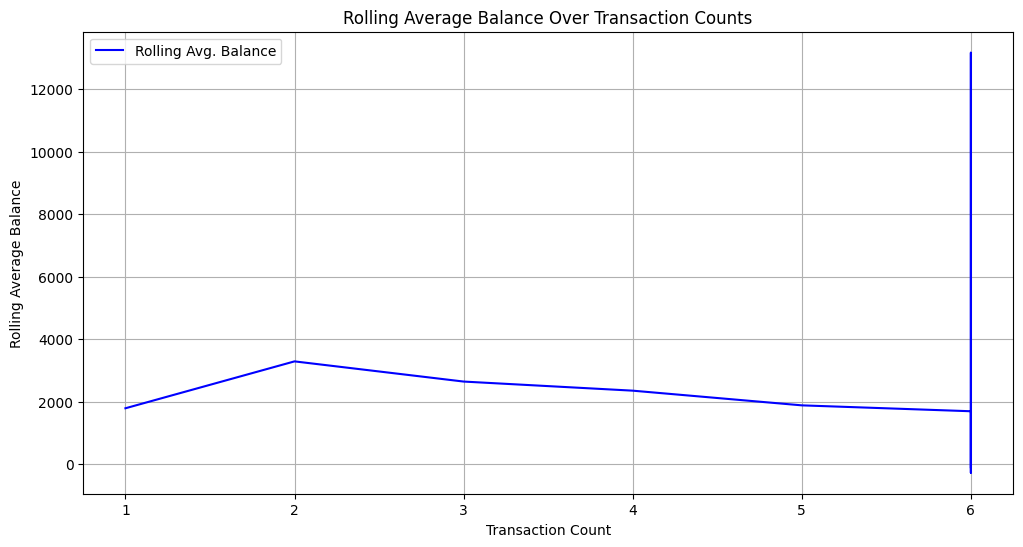

In [64]:
import matplotlib.pyplot as plt

# Extract timestamps and rolling average balance values

balance_values = rolling_avg_balance_df.select("rolling_avg_balance").collect()

transaction_count_values = rolling_avg_transaction_df.select("rolling_avg_transcation").collect()

# Plot rolling average balance
plt.figure(figsize=(12, 6))
plt.plot(transaction_count_values,balance_values, label="Rolling Avg. Balance", color="blue")
plt.xlabel("Transaction Count")
plt.ylabel("Rolling Average Balance")
plt.title("Rolling Average Balance Over Transaction Counts")
plt.legend()
plt.grid(True)
plt.show()

### Handling Late and Out-of-Order Data:
Modify your Spark Streaming application to handle late and out-of-order data using watermarking. Explain your approach and how it improves the accuracy of real-time analytics.

Handling late and out-of-order data is crucial in real-time analytics to ensure the accuracy and reliability of the analysis results. Spark Structured Streaming provides a feature called watermarking to address these challenges effectively.

Watermarking allows Spark to track the event time of data and specify a threshold beyond which late data is considered irrelevant for computations. It works by associating a timestamp with each event and discarding events that arrive after a certain delay relative to the latest event seen so far.

Here's how you can modify your Spark Streaming application to handle late and out-of-order data using watermarking:

1. Define Event Time: Ensure that your streaming data contains a timestamp indicating the event time. This timestamp should represent when the event occurred, not when it was processed.

2. Specify Watermark: Set a watermark for your streaming DataFrame or Dataset using the withWatermark function. This function specifies the maximum delay allowed for late data.

3. Use Event Time in Windowing: When defining window operations (e.g., aggregations over time windows), specify the column representing the event time. This ensures that Spark uses the event time for windowing calculations.

4. Handle Late Data: Spark will automatically handle late data based on the watermark specified. Late data that arrives after the watermark threshold will be considered irrelevant for computations and will be dropped.

5. Ensure Data Ordering: It's essential to ensure that your streaming data is ordered by event time before performing window operations. You can achieve this by sorting your DataFrame or Dataset by the event time column.

6. By implementing watermarking in your Spark Structured Streaming application, you can improve the accuracy of real-time analytics by:

Ensuring that only relevant data within the specified event time window is considered for computations.

Handling out-of-order data gracefully by accommodating delays in data arrival. Preventing over-counting or under-counting of events that arrive late or out of order.

Providing more accurate insights and analytics results based on a complete and consistent view of the data within the defined time windows.

In [65]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, count, avg, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Create a Spark session
spark = SparkSession.builder \
    .appName("TransactionWatermarking") \
    .getOrCreate()

# Create a PySpark DataFrame from the Pandas DataFrame
streaming_df = spark.createDataFrame(df)

# Add a timestamp column using current_timestamp()
streaming_df = streaming_df.withColumn("timestamp", current_timestamp())

# Define watermark for late data handling
watermark_duration = "10 seconds"

# Define window duration and sliding interval
windowDuration = "1 minute"
slideInterval = "30 seconds"

# Cast balance column to double type
streaming_df = streaming_df.withColumn("balance", streaming_df["balance"].cast("double"))

# Apply watermarking to handle late data
streaming_df = streaming_df.withWatermark("timestamp", watermark_duration)

# Sort the DataFrame by timestamp
sorted_df = streaming_df.orderBy("timestamp")

# Define a window specification
window_spec = window("timestamp", windowDuration, slideInterval)

# Calculate a rolling average balance over a window of 6 rows
rolling_avg_balance_df = sorted_df \
    .groupBy(window_spec) \
    .agg(F.avg("balance").alias("rolling_avg_balance"))

# Calculate the count of transactions within the window
rolling_avg_transaction_df = sorted_df \
    .groupBy(window_spec) \
    .agg(count("*").alias("transaction_count"))

rolling_avg_balance_df.show()
rolling_avg_transaction_df.show()

+--------------------+-------------------+
|              window|rolling_avg_balance|
+--------------------+-------------------+
|{2024-09-08 05:54...| 1422.6578190665782|
|{2024-09-08 05:54...| 1422.6578190665782|
+--------------------+-------------------+

+--------------------+-----------------+
|              window|transaction_count|
+--------------------+-----------------+
|{2024-09-08 05:54...|             4521|
|{2024-09-08 05:54...|             4521|
+--------------------+-----------------+

